<a href="https://colab.research.google.com/github/NosenkoArtem/Deep-Learning-and-Bayesian-ML/blob/main/hw_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Support Vector Machine**
In this notebook, let's try to implement the Bayesian Relevant Vector Machine. It will allow us to automatically select features and obtain estimates of uncertainty for forecasting in the model.

## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
%matplotlib inline

In [ ]:
import torch
from torchtext import data
from torchtext import datasets

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

## Data preparation

In [ ]:
data = datasets.load_boston()

In [ ]:
points = data['data']
values = data['target']

In [ ]:
expanded_points = PolynomialFeatures(degree=2).fit_transform(points)
print(expanded_points.shape)

(506, 105)


In [ ]:
training_points, test_points, training_values, test_values = train_test_split(expanded_points, values)
training_values, test_values = training_values.reshape(-1, 1), test_values.reshape(-1, 1)
print(np.shape(training_points), np.shape(test_points), 
      np.shape(training_values), np.shape(test_values))

(379, 105) (127, 105) (379, 1) (127, 1)


# **Regular Linear Regression**

In [ ]:
class LinearRegression():
  def __init__(self):
    pass

  def fit(self, points, values):
    self.weights = np.linalg.solve(np.matmul(points.T, points), np.matmul(points.T, values))

  def predict(self, points):
    return np.matmul(points, self.weights)

In [ ]:
linear_regression_model = LinearRegression()

In [ ]:
linear_regression_model.fit(training_points, training_values)

In [ ]:
test_predictions = linear_regression_model.predict(test_points)

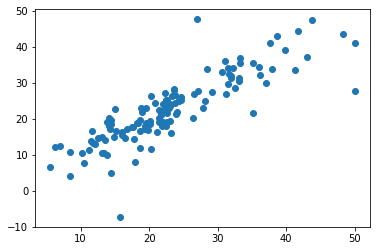

In [ ]:
plt.plot(test_values, test_predictions, 'o')

In [ ]:
r2_score(test_values, test_predictions)

0.6998430471628876

## L-2 regularized Linear Regression

$\hat{w} = \beta A^{-1} X^T y$

$A = \alpha I + \beta X^T X$

In [ ]:
class LinearRegressionL2():
  def __init__(self, beta=1, alpha=0):
    self.alpha = alpha
    self.beta = beta

  def fit(self, points, values):
    self.input_dimension = points.shape[1]
    regularization_matrix = self.alpha * np.eye(self.input_dimension)
    self.weights = self.beta * np.linalg.solve(self.beta * np.dot(points.T, points) + regularization_matrix, 
                                   np.dot(points.T, values))

  def predict(self, points):
    return np.dot(points, self.weights)

In [ ]:
linear_regression_l2_model = LinearRegressionL2(beta=1, alpha=1e-1)

In [ ]:
linear_regression_l2_model.fit(training_points, training_values)

In [ ]:
test_predictions = linear_regression_l2_model.predict(test_points)

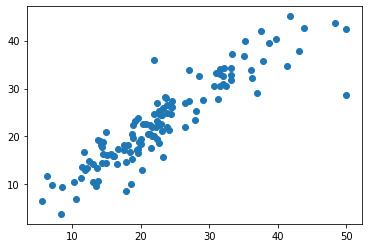

In [ ]:
plt.plot(test_values, test_predictions, 'o')

In [ ]:
r2_score(test_values, test_predictions)

0.8186352646212114

## **Regularization parameteres choice**

In [ ]:
alpha_number = 100
alpha_grid = np.linspace(-20, 10, alpha_number)
alpha_grid = np.exp(alpha_grid)

In [ ]:
r2_values = np.zeros_like(alpha_grid)
for index, alpha in enumerate(alpha_grid):
  linear_regression_l2_model = LinearRegressionL2(alpha=alpha)
  linear_regression_l2_model.fit(training_points, training_values)
  test_predictions = linear_regression_l2_model.predict(test_points)
  r2_values[index] = r2_score(test_values, test_predictions)

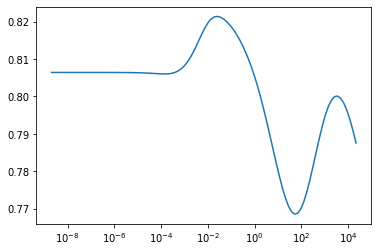

In [ ]:
plt.semilogx(alpha_grid, r2_values);

## **Bayesian approach to the choice of regularization parameters**

Let's try to implement a relevant vector machine.
* $ w $ estimate at each iteration coincides with the values from the previous iteration
* to recalculate $ \ alpha $ and $ \ beta $ we will use iterative formulas for recalculating

$$
  A = \alpha I + \beta X^T X,
$$
$\lambda_i$ - eigenvalues $\beta X^T X$. 


$$
w = \beta A^{-1} X^T y
$$

$$
\gamma = \sum_{i = 1}^d \frac{\lambda_i}{\lambda_i + \alpha}
$$

$$
\alpha = \frac{\gamma}{w^T w}
$$

$$
\frac{1}{\beta} = \frac{1}{n - \gamma} \sum_{i = 1}^n (y_i - \hat{y}_i).
$$

In [ ]:
class BayesianLinearRegression():
  def __init__(self, beta=1, alpha=0):
    self.alpha = alpha
    self.beta = beta

  def fit(self, points, values, iteration_number=30):
    sample_size = points.shape[0]
    self.input_dimension = points.shape[1]
    alpha_history = []
    beta_history = []
    for iteration_index in range(iteration_number):
      regularization_matrix = self.alpha * np.eye(self.input_dimension)
      covariance_matrix = self.beta * np.dot(points.T, points)
      self.weights = self.beta * np.linalg.solve(regularization_matrix + 
                                                 covariance_matrix, 
                                          np.dot(points.T, values))
      lambda_vector, _ = np.linalg.eig(covariance_matrix)
      # print(lambda_vector)
      gamma = np.sum(lambda_vector / (lambda_vector + self.alpha))
      self.alpha = gamma / np.sum(self.weights * self.weights)
      self.beta = (1 / (sample_size - gamma) * 
                   np.sum((values - np.dot(points, self.weights))**2))
      self.beta = 1 / self.beta
      alpha_history.append(self.alpha)
      beta_history.append(self.beta)
    return alpha_history, beta_history

  def predict(self, points):
    return np.dot(points, self.weights)

In [ ]:
bayesian_linear_regression_model = BayesianLinearRegression(beta=1, alpha=1e-1)

In [ ]:
alpha_history, beta_history = bayesian_linear_regression_model.fit(training_points, training_values)

In [ ]:
test_predictions = bayesian_linear_regression_model.predict(test_points)

In [ ]:
r2_score(test_values, test_predictions)

0.7739248182778893

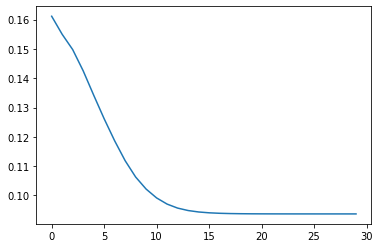

In [ ]:
plt.plot(beta_history)

## Task 1:

* Implement a support vector machine for estimating linear regression and sparsification parameters.
* It follows from the theory that the implemented solution should nullify some of the parameters. Check if this is really the case.

To reevaluate the $\alpha_i$ and $\beta $ parameters, use the following formulas: 

$\alpha_i^{new} = \frac{\gamma_i}{([w_m]_i)^2}$, 

$(\beta_i^{new})^{-1} = \frac{||Y_m-Φw_m^T||^2}{m-\sum_i\gamma_i}$, where

$[w_m]_i$ is the i-th component of the posterior mean

$w_m=βS_mΦ^TY_m$,

$S_m=(α+βΦ^TΦ)^{-1}$.

The parameter $γ_i$ measures how well the corresponding parameter $w_i$ is determined by the data and is defined by

$γ_i = 1−α_i[S_m]_{ii}$.



In [ ]:
class BayesianLinearRegression_spars():
  def __init__(self, beta=1, alpha=0):
    self.alpha = alpha
    self.beta = beta

  def fit(self, points, values, iteration_number=30):
    sample_size = points.shape[0]
    self.input_dimension = points.shape[1]
    self.alpha = np.full_like(np.arange(self.input_dimension), self.alpha).reshape(-1,1)
    alpha_history = []
    beta_history = []
    for iteration_index in range(iteration_number):
      regularization_matrix = self.alpha * np.eye(self.input_dimension)
      
      #YOUR CODE HERE
      covariance_matrix = ... #βΦ^𝑇Φ

      self.weights = self.beta * np.linalg.solve(regularization_matrix + covariance_matrix, 
                                                 np.dot(points.T, values))
      
      #YOUR CODE HERE
      gamma = ...
      
      self.alpha =  ... #update alpha

      # replace very big alpha 
      inf_ind = np.where(self.alpha > 10**5)[0]
      self.alpha[inf_ind] = 10**5

      self.beta = ((1 / (sample_size -  np.sum(gamma))) * 
                   np.linalg.norm(values - np.dot(points, self.weights),2)**2)
      self.beta = 1 / self.beta
      
      alpha_history.append(self.alpha)
      beta_history.append(self.beta)
      if (iteration_index == 0 or iteration_index == (iteration_number - 1)):
        print('regularization_matrix')
        print(regularization_matrix)
        print('covariance_matrix')
        print(covariance_matrix)
        print('weights')
        print(self.weights)        
        print('gamma')
        print(gamma)
        print('alpha')
        print(self.alpha)
        print('beta')
        print(self.beta)
        print('')
        print()
        print('')
        print()
    return alpha_history, beta_history

  def predict(self, points):
    return np.dot(points, self.weights)

  def weights():
    return self.weights

In [ ]:
bayesian_linear_regression_model = BayesianLinearRegression_spars(beta=0.5, alpha=1)

In [ ]:
alpha_history, beta_history = bayesian_linear_regression_model.fit(training_points, training_values, iteration_number=1000)

regularization_matrix
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
covariance_matrix
[[1.89500000e+02 7.18845330e+02 2.34700000e+03 ... 2.58275733e+07
  8.17445257e+05 3.97231595e+04]
 [7.18845330e+02 1.91703009e+04 1.73102600e+02 ... 7.01719286e+07
  3.89412281e+06 3.33903365e+05]
 [2.34700000e+03 1.73102600e+02 1.44376750e+05 ... 3.55948696e+08
  5.91455704e+06 1.24093093e+05]
 ...
 [2.58275733e+07 7.01719286e+07 3.55948696e+08 ... 3.84475508e+12
  1.17199539e+11 4.76203383e+09]
 [8.17445257e+05 3.89412281e+06 5.91455704e+06 ... 1.17199539e+11
  4.76203383e+09 2.46803701e+08]
 [3.97231595e+04 3.33903365e+05 1.24093093e+05 ... 4.76203383e+09
  2.46803701e+08 1.79456609e+07]]
weights
[[-6.40745891e-02]
 [-1.25278132e-01]
 [-3.30434900e-01]
 [-6.69416515e-01]
 [-6.45193466e-02]
 [ 7.38212446e-03]
 [ 1.22513654e+00]
 [ 6.69312927e-01]
 [-3.47547727e-01]
 [ 1.30212636e+00]
 [-1.3

In [ ]:
test_predictions = bayesian_linear_regression_model.predict(test_points)

In [ ]:
r2_score(test_values, test_predictions)

0.7846814762133341

# Task 2:

In this case, the predictive distribution gives not only an estimate of the objective function, but also an estimate of its uncertainty.

$p(t|x,t,α,β)=N(t|m^T_Nφ(x),σ_N^2 (x))$, 

where the variance $σ_N^2 (x$) of the predictive distribution is given by

$σ_N^2 (x) = β_1 + φ(x)^TS_N φ(x).$

You need to
* implement variance() method for Bayesian linear regression
* understand how good the uncertainty estimate is by proposing your criterion.

In [ ]:
class BayesianLinearRegression_var():
  def __init__(self, beta=1, alpha=0):
    self.alpha = alpha
    self.beta = beta

  def fit(self, points, values, iteration_number=30):
    sample_size = points.shape[0]
    self.input_dimension = points.shape[1]
    alpha_history = []
    beta_history = []
    for iteration_index in range(iteration_number):
      regularization_matrix = self.alpha * np.eye(self.input_dimension)
      covariance_matrix = self.beta * np.dot(points.T, points)
      self.weights = self.beta * np.linalg.solve(regularization_matrix + 
                                                 covariance_matrix, 
                                                 np.dot(points.T, values))
      lambda_vector, _ = np.linalg.eig(covariance_matrix)
      gamma = np.sum(lambda_vector / (lambda_vector + self.alpha))
      self.alpha = gamma / np.sum(self.weights * self.weights)
      self.beta = (1 / (sample_size - gamma) * 
                   np.sum((values - np.dot(points, self.weights))**2))
      self.beta = 1 / self.beta
      alpha_history.append(self.alpha)
      beta_history.append(self.beta)

    return alpha_history, beta_history

  def predict(self, points):
    return np.dot(points, self.weights)

  # prediction with variance
  def variance(self, points, rand_num = 1000):
    # variance calculation
    #YOUR CODE HERE
    regularization_matrix = ...
    covariance_matrix = ...
    S = ...
    self.sigma_sq = self.beta * np.eye(points.shape[0]) + np.dot(np.dot(points, S.T), points.T)
    self.sigma_sq = np.diag(self.sigma_sq)

    output = []
    perc_5 = []
    perc_95 = []
    mean = []
    sigma = []
    for i in range(points.shape[0]):

      #YOUR CODE HERE
      mean_i = ... #np.dot return an array with 1 value, get this value
      sigma_i = self.sigma_sq[i]
      #output.append(np.random.normal(mean_i, sigma_i, rand_num))
      mean.append(mean_i) # predicted y
      sigma.append(sigma_i)
      perc_5.append(scipy.stats.norm.ppf(0.05, mean_i, sigma_i))
      perc_95.append(scipy.stats.norm.ppf(0.95, mean_i, sigma_i))
    return mean, sigma, perc_5, perc_95 

In [ ]:
bayesian_linear_regression_model = BayesianLinearRegression_var(beta=1, alpha=1e-1)

In [ ]:
alpha_history, beta_history = bayesian_linear_regression_model.fit(training_points[:200,:], training_values[:200])

In [ ]:
mean, sigma, perc_5, perc_95 = bayesian_linear_regression_model.variance(training_points[:200,:], rand_num = 1000)

In [ ]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Predicted values')

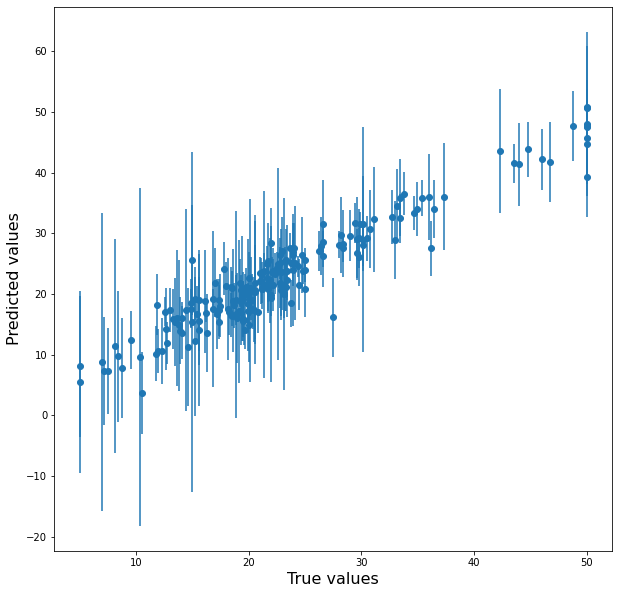

In [ ]:
plt.figure(figsize=(10,10))
y_true = training_values[:200]
y_pred = mean
plt.errorbar(y_true, y_pred, yerr=np.asarray(perc_95) -np.asarray(perc_5), fmt='o', marker=None)
plt.xlabel('True values', fontsize=16)
plt.ylabel('Predicted values', fontsize=16)